In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle

from scripts.smdp_agent import SMDPQLearningAgent
from scripts.intraoption_agent import IntraOptionQLearningAgent
from scripts.taxi_utils import TaxiUtils as tu
from scripts.taxi_visualizer import TaxiVisualizer as tv
from scripts.taxi_visualizer import vis
from scripts.options import Option
from scripts.policies import MoveTaxiPolicy, EpsilonGreedyPolicy, OptimalPolicy, PickUpPassenger, DropOffPassenger, get_initiation_move_taxi, get_termination_move_taxi, get_termination_pick_passenger, get_termination_drop_passenger
from scripts.training import Trainer, trainingInspector, test_agent, plot_test_results, compute_decay

## Hyperparameters

In [2]:
def episode_trigger(x):
    if x % 1000 == 0:
        return True
    return False

def process_hyperparameters(hyperparameters):
    hyperparameters.update({
        "eps_decay": compute_decay(
            hyperparameters["eps_start"],
            hyperparameters["eps_end"],
            hyperparameters["frac_episodes_to_decay"],
            hyperparameters["num_episodes"],
            hyperparameters["decay_type"]
        )
    })

    hyperparameters.pop("frac_episodes_to_decay", None)
    return hyperparameters
    

In [3]:
intraoption_hyperparameter_list = [

    process_hyperparameters(_) for _ in  [
    # Best performing hyperparameters
    {
        "num_episodes": 10000,
        "max_return": 8,
        "LR": 1e-1,
        "eps_start": 1,
        "eps_end": 0.005,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.7
    }

]]

## Running Experiments

In [4]:
color_map = {tu.RED:"Red", tu.GREEN:"Green", tu.YELLOW:"Yellow", tu.BLUE:"Blue"}
options = [
    Option(index = i, 
           initiation_set = get_initiation_move_taxi(tu.COLOR_TO_LOC[color]), 
           policy = MoveTaxiPolicy(tu.COLOR_TO_LOC[color]), 
           termination = get_termination_move_taxi(tu.COLOR_TO_LOC[color]), 
           seed=0,
           label = f"Go To {color_map[color]}"
    )
    for i, color in enumerate([tu.BLUE, tu.YELLOW, tu.GREEN, tu.RED])
]

In [5]:
exp_name = "taxi-intraoption-option1"

env = gym.make('Taxi-v3', render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder=f"backups/{exp_name}-visualizations",
    name_prefix="eval",
    episode_trigger=episode_trigger
)

intraoption_agent = IntraOptionQLearningAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    options=options,
    seed=0
)

trainer = Trainer()
intraoption_results = test_agent(env, intraoption_agent, trainer, intraoption_hyperparameter_list, num_experiments=5)
env.close()

with open(f"backups/{exp_name}-plots/intraoption_option_set_1_results.pickle", 'wb') as handle:
    pickle.dump(intraoption_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"backups/{exp_name}-plots/intraoption_option_set_1_qtable.pickle", 'wb') as handle:
    pickle.dump(intraoption_agent.Qtable, handle, protocol=pickle.HIGHEST_PROTOCOL)

/home/lalit/my_venvs/rl_env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/lalit/acads/DA6400/Assignment3/DA6400_RL_PA3/backups/taxi-intraoption-option1-visualizations folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


LR 0.1
eps_start 1
eps_end 0.005
decay_type exponential
eps_decay 0.9992433838974893


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 586.20it/s, Mean Score=8.1]


LR 0.1
eps_start 1
eps_end 0.005
decay_type exponential
eps_decay 0.9992433838974893


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 547.64it/s, Mean Score=7.05]


LR 0.1
eps_start 1
eps_end 0.005
decay_type exponential
eps_decay 0.9992433838974893


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 522.48it/s, Mean Score=7.16]


LR 0.1
eps_start 1
eps_end 0.005
decay_type exponential
eps_decay 0.9992433838974893


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 546.78it/s, Mean Score=7.01]


LR 0.1
eps_start 1
eps_end 0.005
decay_type exponential
eps_decay 0.9992433838974893


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 553.01it/s, Mean Score=8.01]


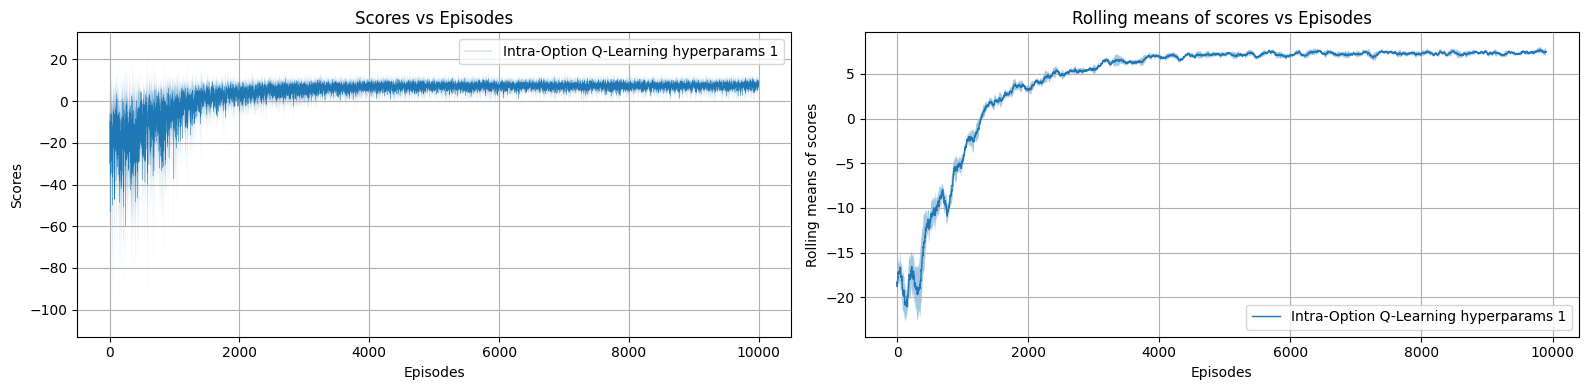

In [6]:
plot_test_results(intraoption_results, [0])

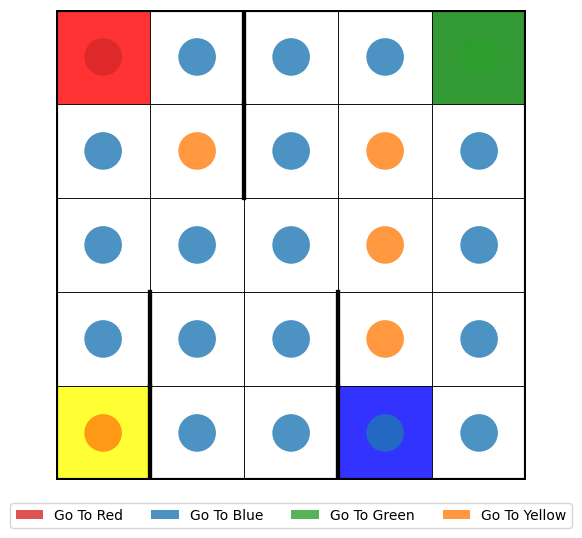

In [7]:
option_labels = {}
for option in options:
    option_labels[option.index] = option.label
    
Qtable = np.reshape(intraoption_agent.Qtable, (5,5,5,4,-1))
vis(tu.encode_env_state(3, 3, tu.IN_TAXI, tu.BLUE), Qtable, option_labels)